### 뚝섬 한강 공원 주차장 분석

- 뚝섬 한강 공원의 주차장 혼잡도(여유, 보통, 혼잡, 만차)를 시간별로 예측
- 데이터 전처리, feature, taregt 선별 

In [ ]:
# 세팅
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno  # nan 값 확인용
import holiday

In [39]:
# 한글 폰트 문제 해결 
# matplotlib은 한글 폰트를 지원하지 않음
# os정보
import platform
import matplotlib.pyplot as plt

# font_manager : 폰트 관리 모듈
# rc : 폰트 변경 모듈
from matplotlib import font_manager, rc
# unicode 설정
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic') # os가 macos
elif platform.system() == 'Windows':
    path = 'c:/Windows/Fonts/malgun.ttf' # os가 windows
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print("Unknown System")


------
## 데이터 보기

In [40]:
# 기본 데이터 불러오기
df=pd.read_csv('../../Data/한강공원 주차장 일별 이용 현황.csv', encoding='euc-kr')
df.head()


,지구별,주차장명,주차대수,이용시간,날짜
0,PLT-005,뚝섬1주차장,273,22891,2024/11/10
1,PLT-011,잠실1주차장,1059,66361,2024/11/10
2,PLT-001,강서1주차장,329,26875,2024/11/10
3,PLT-008,여의도5주차장,229,22509,2024/11/10
4,PLT-008,여의도2주차장,1934,150135,2024/11/10


In [41]:
# 결측치 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45277 entries, 0 to 45276
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   지구별     45277 non-null  object
 1   주차장명    45277 non-null  object
 2   주차대수    45277 non-null  int64 
 3   이용시간    45277 non-null  int64 
 4   날짜      45277 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.7+ MB


> 주차장 일별 데이터 결측치 X

### 전체 데이터에서 뚝섬한강공원 데이터만 추출

In [42]:
df_dd = df[df['지구별'] == 'PLT-005']
df_dd.head()

,지구별,주차장명,주차대수,이용시간,날짜
0,PLT-005,뚝섬1주차장,273,22891,2024/11/10
10,PLT-005,뚝섬3주차장,686,62848,2024/11/10
16,PLT-005,뚝섬4주차장,864,79419,2024/11/10
21,PLT-005,뚝섬2주차장,965,108345,2024/11/10
30,PLT-005,뚝섬2주차장,850,91910,2024/11/09


In [43]:
# index 정리
df_dd.reset_index(drop=True, inplace=True)
df_dd.head()

,지구별,주차장명,주차대수,이용시간,날짜
0,PLT-005,뚝섬1주차장,273,22891,2024/11/10
1,PLT-005,뚝섬3주차장,686,62848,2024/11/10
2,PLT-005,뚝섬4주차장,864,79419,2024/11/10
3,PLT-005,뚝섬2주차장,965,108345,2024/11/10
4,PLT-005,뚝섬2주차장,850,91910,2024/11/09


In [44]:
df_dd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6956 entries, 0 to 6955
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   지구별     6956 non-null   object
 1   주차장명    6956 non-null   object
 2   주차대수    6956 non-null   int64 
 3   이용시간    6956 non-null   int64 
 4   날짜      6956 non-null   object
dtypes: int64(2), object(3)
memory usage: 271.8+ KB


In [45]:
# 주차장 갯수 확인
# 1부터 4까지의 주차장 보유
df_dd['주차장명'].unique()

array(['뚝섬1주차장', '뚝섬3주차장', '뚝섬4주차장', '뚝섬2주차장'], dtype=object)

In [ ]:
# 이용시간 0값 확인
df_dd.describe()

,주차대수,이용시간
count,6956.000000,6956.000000
mean,526.861415,52692.554198
std,350.742185,41924.445747
min,1.000000,0.000000
25%,250.000000,19991.000000
50%,460.000000,44253.000000
75%,702.000000,71251.750000
max,2999.000000,291616.000000


In [ ]:

df_dd[df_dd['이용시간'] == 0].sort_values('주차장명')

,지구별,주차장명,주차대수,이용시간,날짜
4002,PLT-005,뚝섬1주차장,135,0,2022/02/06
6167,PLT-005,뚝섬1주차장,2,0,2020/08/12
6169,PLT-005,뚝섬1주차장,2,0,2020/08/11
4004,PLT-005,뚝섬2주차장,346,0,2022/02/06
4001,PLT-005,뚝섬3주차장,188,0,2022/02/06
6165,PLT-005,뚝섬3주차장,6,0,2020/08/12
6168,PLT-005,뚝섬3주차장,4,0,2020/08/11
6180,PLT-005,뚝섬3주차장,2,0,2020/08/07
4003,PLT-005,뚝섬4주차장,292,0,2022/02/06
6181,PLT-005,뚝섬4주차장,1,0,2020/08/06


> 주차대수는 있지만 이용시간이 0으로 작성된 것을 확인

#### 0값을 월 & (요일) & 주차장명 별 1대당 평균 이용시간으로 대치하기 위함

In [ ]:


df_dd['날짜']=pd.to_datetime(df_dd['날짜'])

In [50]:
df_dd['년도'] = df_dd['날짜'].dt.year
df_dd['월'] = df_dd['날짜'].dt.month
df_dd['일'] = df_dd['날짜'].dt.day

In [52]:
df_dd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6956 entries, 0 to 6955
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   지구별     6956 non-null   object        
 1   주차장명    6956 non-null   object        
 2   주차대수    6956 non-null   int64         
 3   이용시간    6956 non-null   int64         
 4   날짜      6956 non-null   datetime64[ns]
 5   년도      6956 non-null   int32         
 6   월       6956 non-null   int32         
 7   일       6956 non-null   int32         
dtypes: datetime64[ns](1), int32(3), int64(2), object(2)
memory usage: 353.4+ KB


In [ ]:
# df_dd['평균주차시간'] = 
# df_dd['평균 이용시간']=df_dd['이용시간']/df_dd['주차대수']

In [36]:
# 주차장 갯수 확인
# 1부터 4까지의 주차장 보유
df_dd['주차장명'].unique()

array(['뚝섬1주차장', '뚝섬3주차장', '뚝섬4주차장', '뚝섬2주차장'], dtype=object)

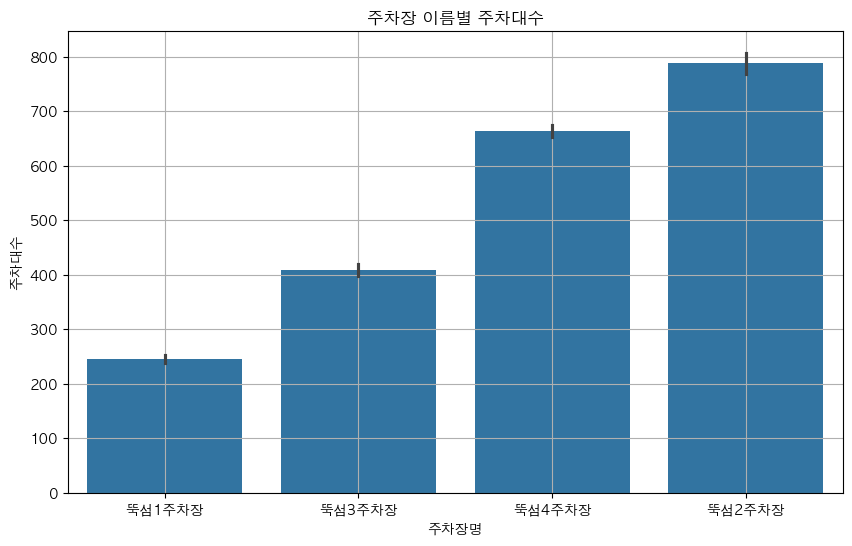

In [ ]:

# 산포도 그리기
plt.figure(figsize=(10, 6))
sns.barplot(data=df_dd, x='주차장명', y='주차대수')

# 그래프 제목과 라벨 설정
plt.title('주차장 이름별 주차대수')
plt.xlabel('주차장명')
plt.ylabel('주차대수')
plt.grid()

# 그래프 보여주기
plt.show()
